# Phase 2 - Transfer Learning on CIFAR10

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
import os
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
import numpy as np

## 1) Download and Load CIFAR10

You can find CIFAR10 in ```torchvision.datasets.CIFAR10()``` or see [here](https://pytorch.org/vision/0.15/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10). Please Download the dataset and use Dataloaders to load it.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 64

train_set = datasets.CIFAR10(root = './data', train = True, transform = transform, download = True)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                             batch_size = batch_size,
                                             shuffle = True)

testset = datasets.CIFAR10(root = './data', train = False, transform = transform, download = True)

test_loader = torch.utils.data.DataLoader(dataset = testset,
                                             batch_size = batch_size,
                                             shuffle = True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2) Load Pretrained Model (ResNet18) and Modify Layers
Load ResNet18 model from ```torchvision.models.resnet18()```, make sure to load pretrained model with weights.
You will need to modify the final layer. ResNet outputs 100 lables - please change to the correct output dimension.

In [3]:
# Instantiate Pretrained ResNet18
resnet18 = models.resnet18(pretrained=True)

# Modify final layer
resnet18.fc = nn.Linear(in_features=512, out_features=len(classes), bias=True)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# View Model to validate
print(resnet18)

/opt/anaconda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3) Train and Test Functions
You can refer to Phase_1.ipynb to complete these functions. In ```train()```, rather than saving the accuracy and loss per iteration, you will need to save the loss and accuracy ***per epoch***

In [4]:
def test_accuracy(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].to(device), test_data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.view(-1).tolist())
            y_true.extend(labels.view(-1).tolist())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy,y_true, y_pred



def partial_test_accuracy(model, test_loader, device, loss_fn):
    model.to(device)
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        i = 0
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = loss_fn(outputs, labels)
            losses.append(loss.item())
            i += 1
            if i % 100 == 0:
                break
    return (100 * correct / total), sum(losses) / len(losses)

def train(model, loss_fn, optimizer, train_loader, test_loader, batch_size, num_epochs, device):
    losses = []
    train_accs = []
    test_accs = []
    val_losses = []

    epoch_loss = []
    start_time = time.time()
    for epoch in range(num_epochs):
        # Iterate through the training dataset
        for i, data in enumerate(train_loader, 0):
            # Load images and labels and move them to the device
            images, labels = data[0].to(device), data[1].to(device)
            # Zero out any gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_fn(outputs, labels)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Print statistics every 100 iterations
            epoch_loss.append(loss.item())
            if (i+1) % 50 == 0:
                print(f"Step: [{i+1}/{len(train_loader)}]")


        end_time = time.time()
        loss = sum(epoch_loss) / len(epoch_loss)
        train_acc, _ = partial_test_accuracy(model, train_loader, device, loss_fn)
        test_acc, val_loss = partial_test_accuracy(model, test_loader, device, loss_fn)
        losses.append(loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print('Epoch [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}, Runtime: {:.4f} s'
                        .format(epoch+1, num_epochs, loss, val_loss, train_acc, test_acc, end_time - start_time))

        epoch_loss = []
        start_time = time.time()

        epoch_axis = np.linspace(0, epoch, len(losses))
        plot_learning_curve(epoch_axis, losses, val_losses, train_accs, test_accs, title=f"Epoch {epoch+1}")
    return losses, val_losses, train_accs, test_accs

def plot_learning_curve(epochs, losses, val_losses, train_accs, test_accs, title=''):
    plt.plot(epochs, losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title + " Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, test_accs, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title + " Accuracies")
    plt.legend()
    plt.show()

## 4) Complete full training and testing pipeline
Retrain the ResNet18 on CIFAR10 Dataset. You can chose the optimizer and loss function.

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [1/20], Loss: 0.9526, Val Loss: 0.7598, Train Accuracy: 77.8906, Test Accuracy: 74.0156, Runtime: 26.3753 s


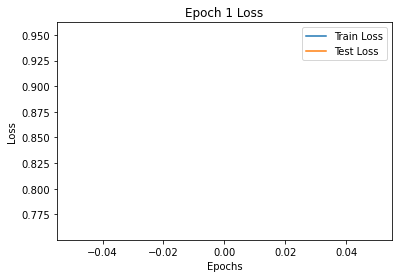

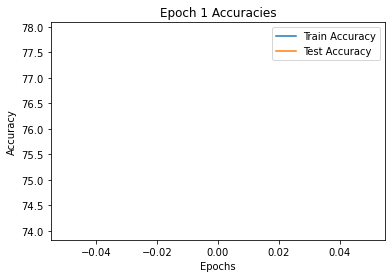

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [2/20], Loss: 0.6501, Val Loss: 0.6590, Train Accuracy: 85.0000, Test Accuracy: 78.2969, Runtime: 24.4957 s


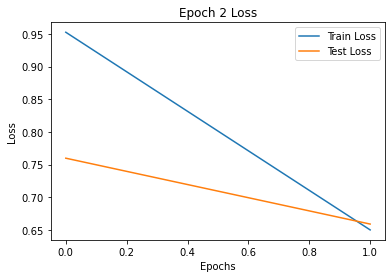

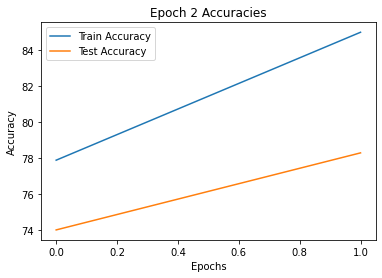

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [3/20], Loss: 0.5210, Val Loss: 0.6210, Train Accuracy: 87.9219, Test Accuracy: 78.9844, Runtime: 23.3537 s


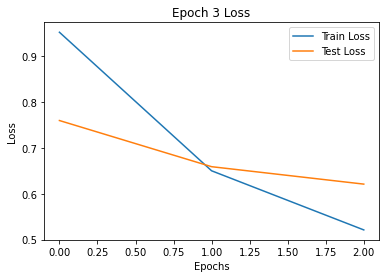

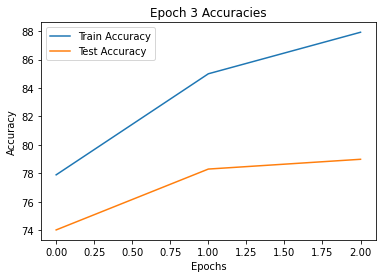

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [4/20], Loss: 0.4185, Val Loss: 0.6164, Train Accuracy: 91.2031, Test Accuracy: 79.3906, Runtime: 23.3598 s


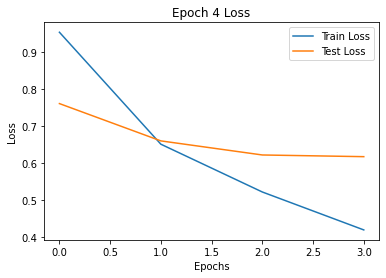

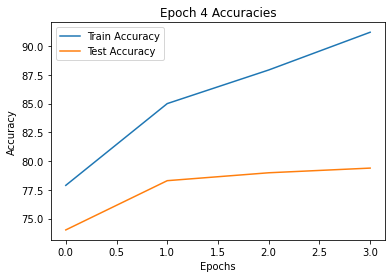

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [5/20], Loss: 0.3536, Val Loss: 0.6465, Train Accuracy: 92.1719, Test Accuracy: 80.0781, Runtime: 22.9161 s


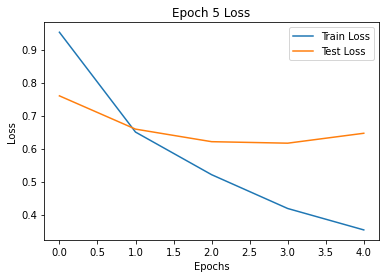

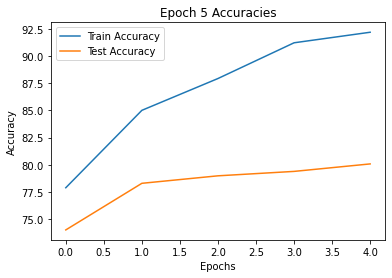

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [6/20], Loss: 0.2672, Val Loss: 0.6808, Train Accuracy: 94.0625, Test Accuracy: 79.4375, Runtime: 23.2787 s


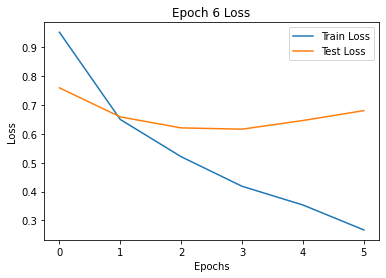

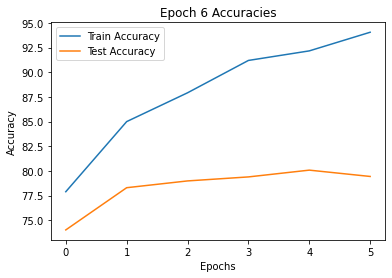

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [7/20], Loss: 0.2191, Val Loss: 0.6985, Train Accuracy: 95.2656, Test Accuracy: 79.9375, Runtime: 19.8994 s


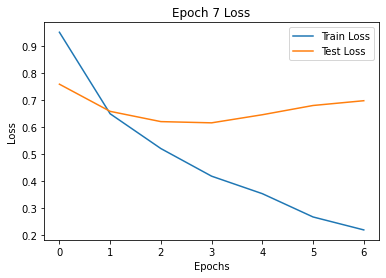

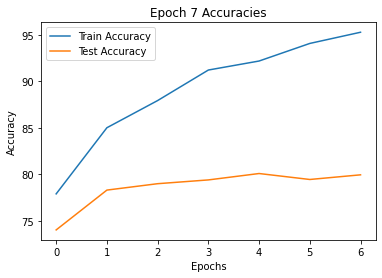

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [8/20], Loss: 0.1791, Val Loss: 0.7075, Train Accuracy: 96.7969, Test Accuracy: 80.4844, Runtime: 20.2455 s


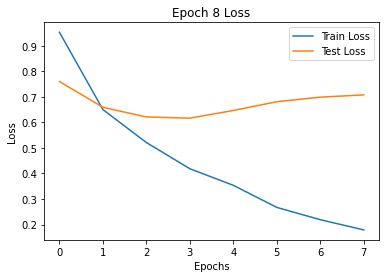

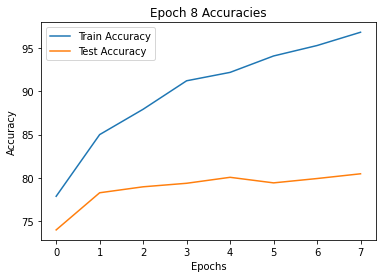

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [9/20], Loss: 0.1576, Val Loss: 0.7419, Train Accuracy: 96.4375, Test Accuracy: 80.2188, Runtime: 22.0682 s


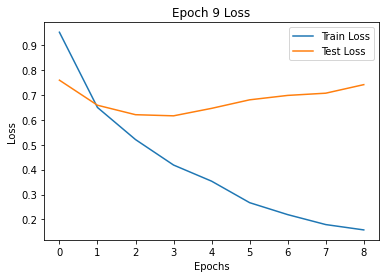

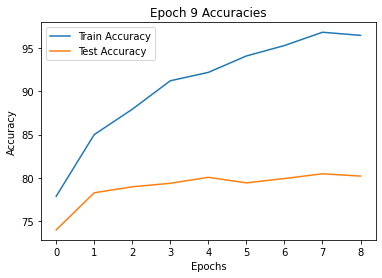

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [10/20], Loss: 0.1186, Val Loss: 0.7726, Train Accuracy: 97.4531, Test Accuracy: 80.6250, Runtime: 26.9604 s


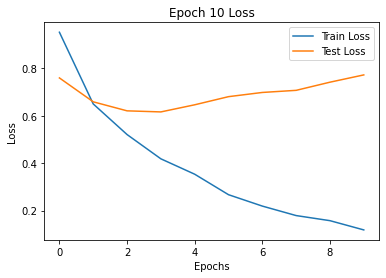

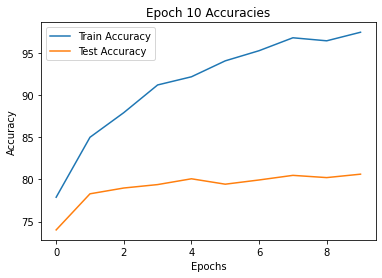

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [11/20], Loss: 0.1018, Val Loss: 0.8515, Train Accuracy: 98.0156, Test Accuracy: 79.8906, Runtime: 26.6990 s


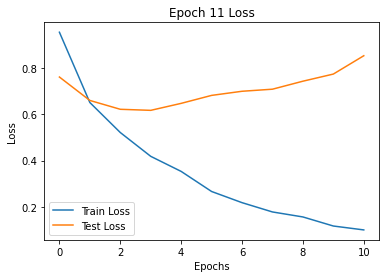

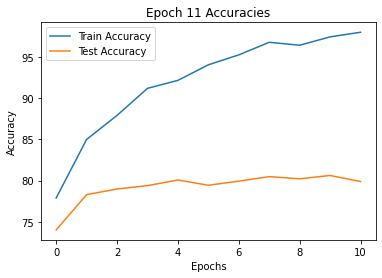

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [12/20], Loss: 0.0995, Val Loss: 0.8286, Train Accuracy: 97.6875, Test Accuracy: 80.5938, Runtime: 27.1049 s


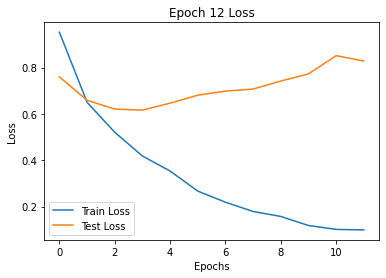

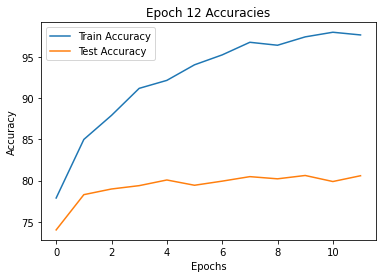

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [13/20], Loss: 0.0830, Val Loss: 0.9047, Train Accuracy: 97.8906, Test Accuracy: 80.0156, Runtime: 24.7916 s


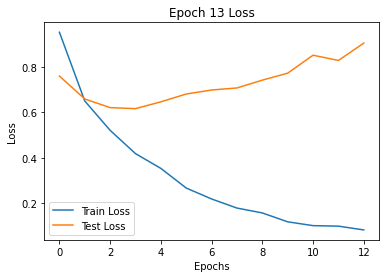

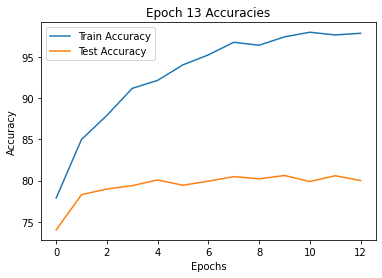

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [14/20], Loss: 0.0838, Val Loss: 0.9216, Train Accuracy: 97.8281, Test Accuracy: 80.2188, Runtime: 22.9863 s


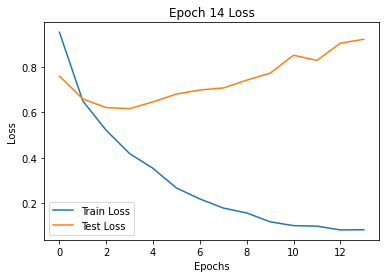

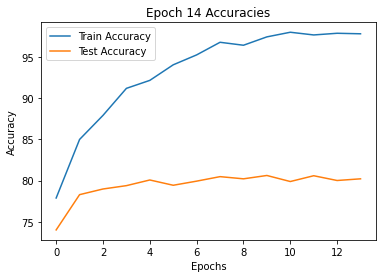

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [15/20], Loss: 0.0785, Val Loss: 0.8749, Train Accuracy: 98.3750, Test Accuracy: 80.0781, Runtime: 22.9573 s


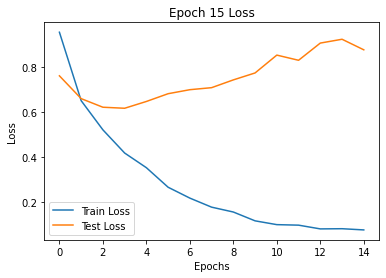

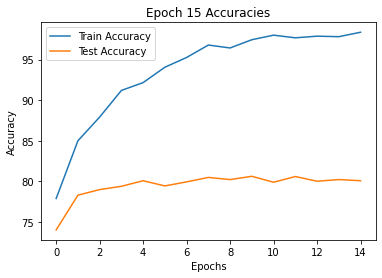

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [16/20], Loss: 0.0700, Val Loss: 0.9416, Train Accuracy: 98.3125, Test Accuracy: 80.1719, Runtime: 23.1595 s


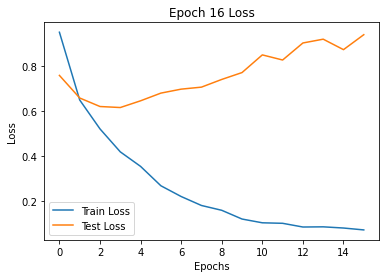

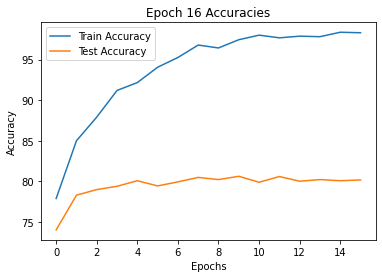

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [17/20], Loss: 0.0595, Val Loss: 0.9783, Train Accuracy: 98.4219, Test Accuracy: 79.6875, Runtime: 23.1256 s


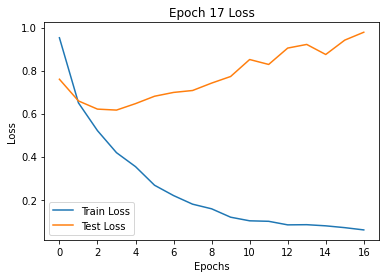

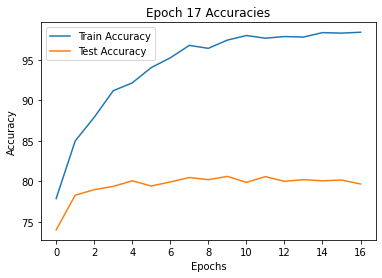

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [18/20], Loss: 0.0663, Val Loss: 0.9572, Train Accuracy: 98.7969, Test Accuracy: 81.1406, Runtime: 26.4315 s


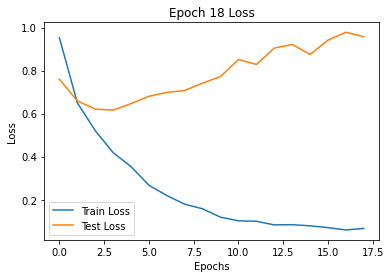

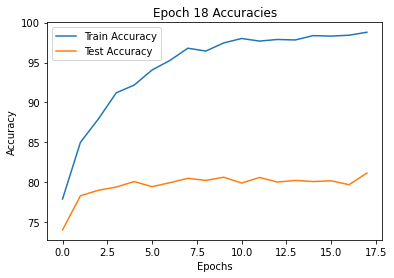

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [19/20], Loss: 0.0702, Val Loss: 1.0118, Train Accuracy: 98.7031, Test Accuracy: 79.9844, Runtime: 26.9867 s


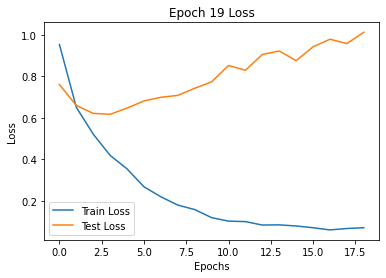

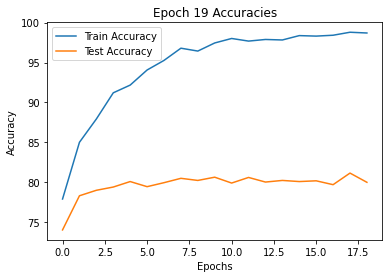

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [20/20], Loss: 0.0698, Val Loss: 0.9183, Train Accuracy: 98.3438, Test Accuracy: 80.8750, Runtime: 26.6307 s


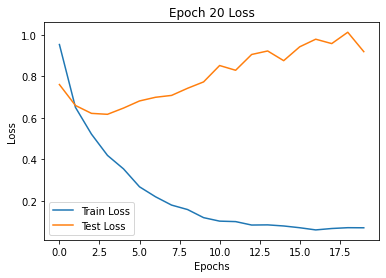

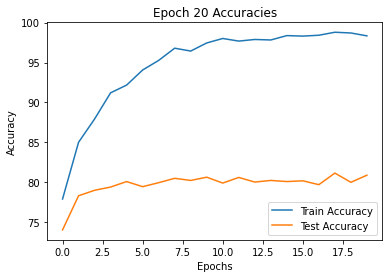

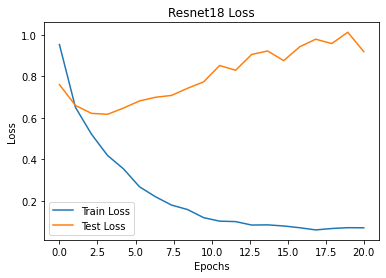

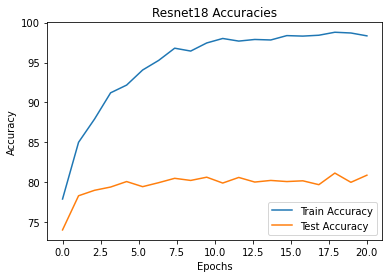

81.09


In [5]:
# Define Parameters
input_size = 196608
num_classes = len(classes)
num_epochs = 20
lr = 1e-3


# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)


losses, val_losses, train_accs, test_accs = train(model=resnet18, loss_fn=loss_function, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader,
               batch_size=batch_size, num_epochs=num_epochs, device=device)
epochs = np.linspace(0, num_epochs, len(losses))

plot_learning_curve(epochs, losses, val_losses, train_accs, test_accs, title="Resnet18")
ta, y_true,y_predict = test_accuracy(resnet18,test_loader,device)

print(ta)

In [6]:
print(losses)

[0.95257406134892, 0.6500781588161083, 0.5209853822541664, 0.41852155211560255, 0.35362206488523795, 0.26717926860046204, 0.2191306445985804, 0.17912973080525924, 0.15762513046345825, 0.11860207207572392, 0.10181613396281552, 0.09953624182476012, 0.0829799315029317, 0.0838097858324866, 0.0784866528989285, 0.07003247738479997, 0.05950046884184203, 0.06629351492914017, 0.07021472196403147, 0.06977359520460781]


## 5) Confusion Matrix

Write code to plot a confusion matrix after training the above ResNet18. Please make sure the axis have class names (defined in Section 1)

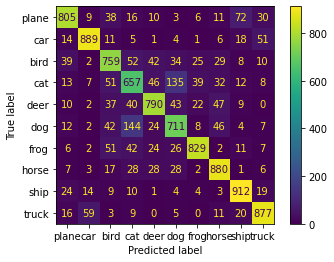

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1000
           1       0.90      0.89      0.89      1000
           2       0.75      0.76      0.75      1000
           3       0.66      0.66      0.66      1000
           4       0.82      0.79      0.80      1000
           5       0.72      0.71      0.71      1000
           6       0.89      0.83      0.86      1000
           7       0.82      0.88      0.85      1000
           8       0.85      0.91      0.88      1000
           9       0.86      0.88      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [7]:
ta,y_true, y_pred = test_accuracy(resnet18, test_loader, device)

# Compute and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

# Compute and print the classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

## 6) Freeze Network

### 6.1) Initialize a new ResNEt18, Freeze the model weights except last layer, modify the last layer so we only train the last layer.

In [8]:
# Instantiate Pretrained ResNet18
resnet18_frz = models.resnet18(pretrained=True)

# Freeze all layers (except last)
for name, p in resnet18_frz.named_parameters():      
    if name != "fc.weight" and name != "fc.bias":
        p.requires_grad = False

# Modify final layer
resnet18_frz.fc = nn.Linear(in_features=512, out_features=len(classes), bias=True)

for name, p in resnet18_frz.named_parameters():
    print("param name:", name, "requires_grad:", p.requires_grad)
# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18_frz.to(device)

# View Model to validate
print(resnet18_frz)

/opt/anaconda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


param name: conv1.weight requires_grad: False
param name: bn1.weight requires_grad: False
param name: bn1.bias requires_grad: False
param name: layer1.0.conv1.weight requires_grad: False
param name: layer1.0.bn1.weight requires_grad: False
param name: layer1.0.bn1.bias requires_grad: False
param name: layer1.0.conv2.weight requires_grad: False
param name: layer1.0.bn2.weight requires_grad: False
param name: layer1.0.bn2.bias requires_grad: False
param name: layer1.1.conv1.weight requires_grad: False
param name: layer1.1.bn1.weight requires_grad: False
param name: layer1.1.bn1.bias requires_grad: False
param name: layer1.1.conv2.weight requires_grad: False
param name: layer1.1.bn2.weight requires_grad: False
param name: layer1.1.bn2.bias requires_grad: False
param name: layer2.0.conv1.weight requires_grad: False
param name: layer2.0.bn1.weight requires_grad: False
param name: layer2.0.bn1.bias requires_grad: False
param name: layer2.0.conv2.weight requires_grad: False
param name: layer2

### 6.2) Retrain the frozen ResNet18 now with the same setup as the previous ResNEt18 (same batch size, optimizer, learning rate, etc.)

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [1/10], Loss: 1.5119, Val Loss: 1.6040, Train Accuracy: 49.0000, Test Accuracy: 45.3906, Runtime: 11.7309 s


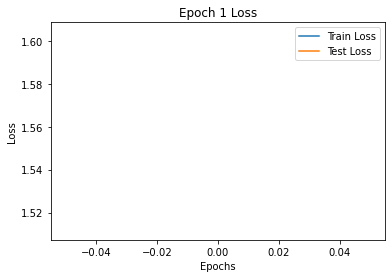

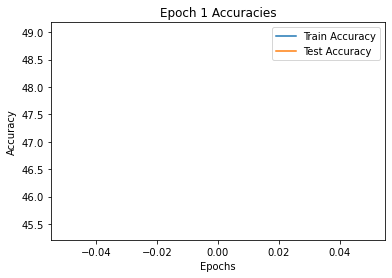

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [2/10], Loss: 1.5099, Val Loss: 1.5851, Train Accuracy: 49.4219, Test Accuracy: 45.6094, Runtime: 12.6388 s


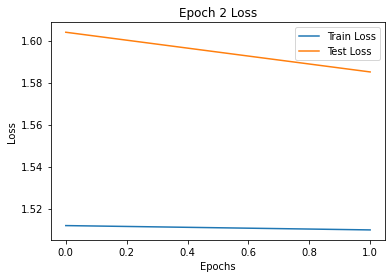

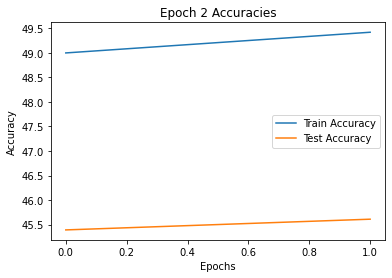

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [3/10], Loss: 1.5077, Val Loss: 1.5941, Train Accuracy: 48.4219, Test Accuracy: 44.7344, Runtime: 12.5458 s


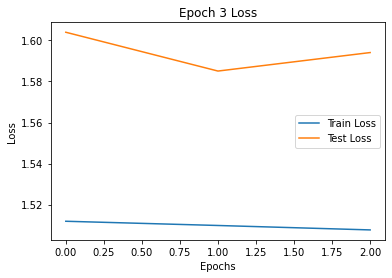

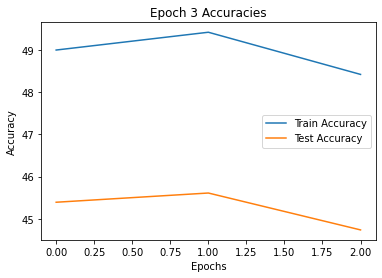

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [4/10], Loss: 1.5077, Val Loss: 1.5893, Train Accuracy: 48.6562, Test Accuracy: 45.6562, Runtime: 12.3926 s


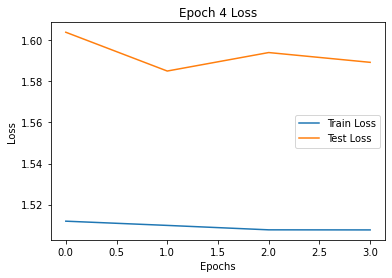

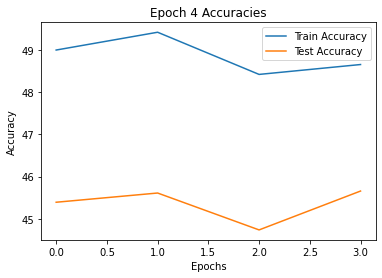

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [5/10], Loss: 1.5069, Val Loss: 1.5866, Train Accuracy: 47.9844, Test Accuracy: 46.0781, Runtime: 12.4787 s


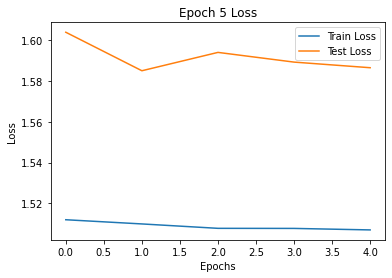

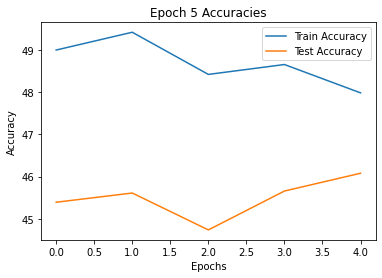

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [6/10], Loss: 1.5063, Val Loss: 1.5866, Train Accuracy: 48.9062, Test Accuracy: 45.2812, Runtime: 12.4954 s


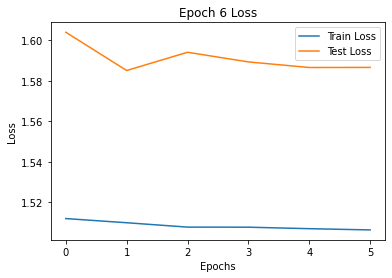

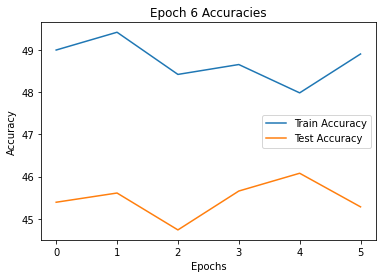

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [7/10], Loss: 1.5094, Val Loss: 1.5644, Train Accuracy: 48.7500, Test Accuracy: 46.0469, Runtime: 12.5491 s


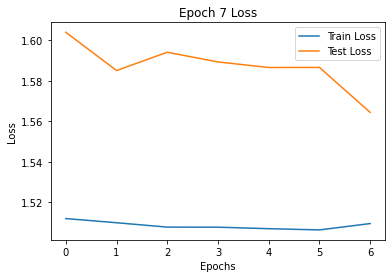

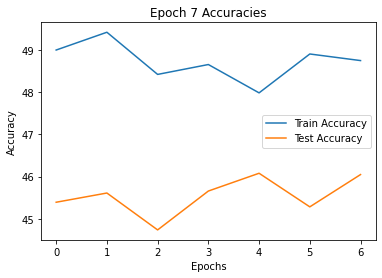

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [8/10], Loss: 1.5077, Val Loss: 1.5755, Train Accuracy: 47.8438, Test Accuracy: 45.7031, Runtime: 11.3113 s


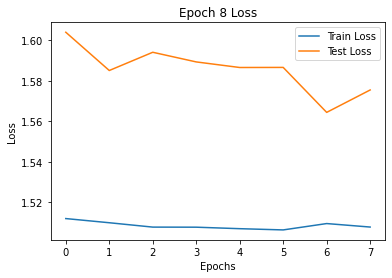

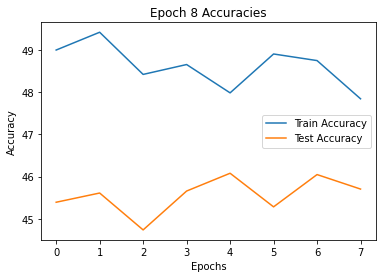

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [9/10], Loss: 1.5071, Val Loss: 1.5875, Train Accuracy: 47.4688, Test Accuracy: 45.1875, Runtime: 11.6447 s


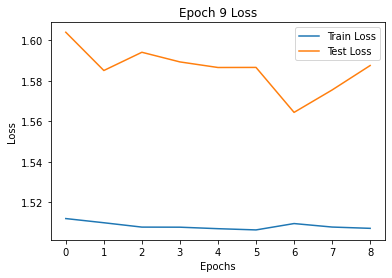

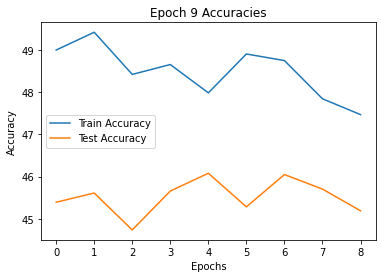

Step: [50/782]
Step: [100/782]
Step: [150/782]
Step: [200/782]
Step: [250/782]
Step: [300/782]
Step: [350/782]
Step: [400/782]
Step: [450/782]
Step: [500/782]
Step: [550/782]
Step: [600/782]
Step: [650/782]
Step: [700/782]
Step: [750/782]
Epoch [10/10], Loss: 1.5058, Val Loss: 1.6092, Train Accuracy: 48.4062, Test Accuracy: 45.4531, Runtime: 12.0081 s


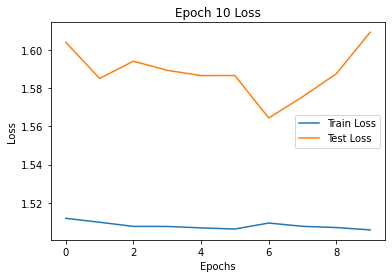

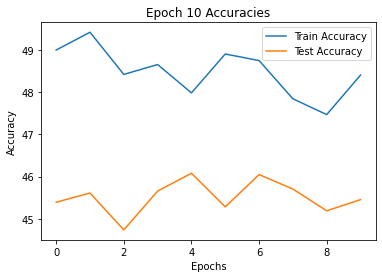

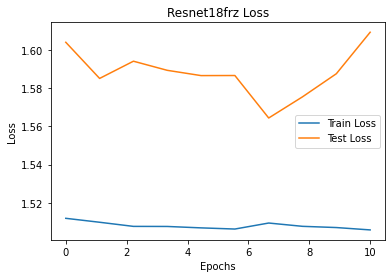

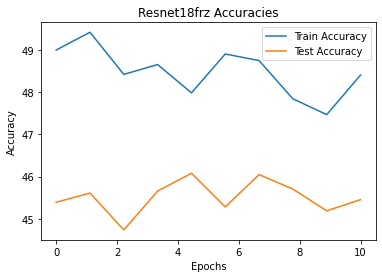

45.77


In [13]:
# Define Parameters
num_epochs = 10
''' TODO '''

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_frz.parameters(), lr=lr)

# Train Model
losses, val_losses, train_accs, test_accs = train(model=resnet18_frz, loss_fn=loss_function, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader,
               batch_size=batch_size, num_epochs=num_epochs, device=device)
epochs = np.linspace(0, num_epochs, len(losses))

plot_learning_curve(epochs, losses, val_losses, train_accs, test_accs, title="Resnet18frz")
ta, y_true,y_predict = test_accuracy(resnet18_frz,test_loader,device)

print(ta)

## 6.3) Confusion Matrix (Frozen)

Use the same code as section 5, but now plot the confusion matrix for the results of the frozen network.

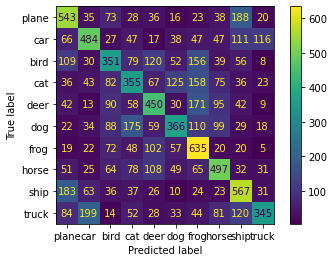

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.54      0.50      1000
           1       0.51      0.48      0.50      1000
           2       0.39      0.35      0.37      1000
           3       0.37      0.35      0.36      1000
           4       0.44      0.45      0.45      1000
           5       0.47      0.37      0.41      1000
           6       0.44      0.64      0.52      1000
           7       0.49      0.50      0.49      1000
           8       0.47      0.57      0.52      1000
           9       0.57      0.34      0.43      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000



In [10]:
ta,y_true, y_pred = test_accuracy(resnet18_frz, test_loader, device)

# Compute and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

# Compute and print the classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

## 7) Reporting

Please answer the following questions based on the training and learning curves from the previous sections.

#### Q 7.1) What is transfer learning and why would it be useful?

#### Q 7.2) What (if any) modifications to the pretrained model would you need to do and why?

#### Q 7.3) Why would you retrain from a pretrained network? What is advantage of not re-initalizing the pre-trained network.

#### Q 7.4) Please explain precision and recall.

#### Q 7.5) Explain what a confusion matrix is. Use your output confusion matrix as an example.

#### Q 7.6) What was the difference between freezing layers and retraining all? Explain in terms of classification metrics and why you saw such metrics and confusuon matrix. Is what you say as expected?

#### Q 7.7) For a pretrained model like ResNet, in what general scenarios would you (1) freeze your pretrained weights adn retrain last layer, (2) retrain entire architecture, and (3) Freeze all convolution layer weights and retrain all FC layers? Explain with example scenarios if possible.